In [1]:
import os
import time
import json
import joblib
import datetime

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

np.random.seed(42)

In [2]:
CONFIG = {
    'timestamp'             : str(datetime.datetime.now()),
    'model'                 : 'Random Forest PyAudioAnalysis Features',
    'test_fold'             : 'Fold 5',
#     'C'                     : 3,
    'criterion'             : 'gini',
    'n_estimators'          : 32,
    'max_depth'             : 16,
#     'class_weight'          : { 0: 0.71, 1:  2.32, 2: 0.86 },
    'training_time'         : 0,
    'testing_time'          : 0,
    'cm_atick'              : '',
    'cr_atick'              : '',
    'cm_valentina'          : '',
    'cr_valentina'          : ''
}

In [3]:
BASE_DIR            = os.getcwd()

LOG_FILE            = '../logs/classical_ml.txt'
EMOTIONS            = ['Approval', 'Disapproval', 'Neutral']
FOLDS               = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

FEATURES_DIR_AF     = '../../Dataset/Features-AF/'
FEATURES_DIR_VAL    = '../../Dataset/Features-VAL/'

In [4]:
features_path_af = os.path.join(BASE_DIR, FEATURES_DIR_AF, 'Features.joblib')
features_af = joblib.load(features_path_af)

features_path_val = os.path.join(BASE_DIR, FEATURES_DIR_VAL, 'Features.joblib')
features_val = joblib.load(features_path_val)

In [5]:
X_AF  = features_af.drop(['fold', 'label'], axis=1).to_numpy()
y_AF  = features_af['label'].to_numpy()
f_AF  = features_af['fold'].to_numpy()

X_VAL = features_val.drop(['fold', 'label'], axis=1).to_numpy()
y_VAL = features_val['label'].to_numpy()

In [6]:
mask       = (f_AF == FOLDS.index(CONFIG['test_fold']))
train_X    = X_AF[~mask, :]
train_y    = y_AF[~mask]
val_X      = X_AF[mask, :]
val_y      = y_AF[mask]
test_X     = X_VAL
test_y     = y_VAL

In [7]:
clf = RandomForestClassifier(
    n_estimators          = CONFIG['n_estimators'],
    criterion             = CONFIG['criterion'],
    max_depth             = CONFIG['max_depth'],
#     class_weight          = CONFIG['class_weight'],
    verbose               = 1,
)

# clf = SVC(
#     C                     = CONFIG['C'],
#     class_weight          = CONFIG['class_weight'],
#     verbose               = 1,
# )

In [8]:
train_X, train_y = shuffle(train_X, train_y)
pipe = Pipeline([('scaler', StandardScaler()), ('svm', clf)])

start_time = time.time()
pipe.fit(train_X, train_y)
training_time = time.time() - start_time

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.7s finished


In [9]:
# ------------------ Testing on Aticks's data -----------------

y_true = val_y
y_pred = pipe.predict(val_X)

result_atick = classification_report(y_true, y_pred)
print(result_atick)

              precision    recall  f1-score   support

         0.0       0.95      0.88      0.92       677
         1.0       0.93      0.98      0.95       253
         2.0       0.87      0.92      0.90       605

    accuracy                           0.91      1535
   macro avg       0.92      0.93      0.92      1535
weighted avg       0.92      0.91      0.91      1535



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished


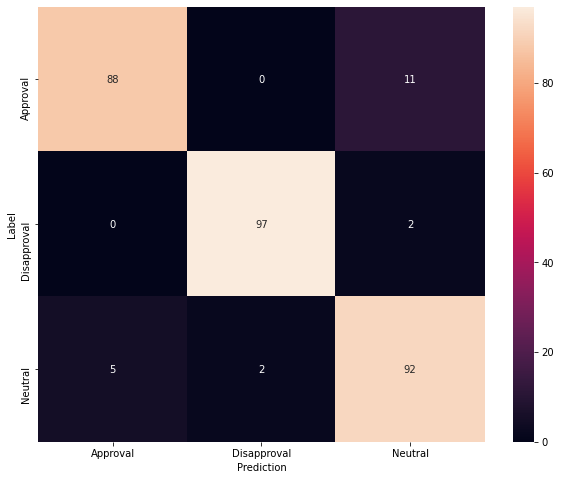

In [10]:
# confusion_mtx_atick = tf.math.confusion_matrix(y_true, y_pred) 
confusion_mtx_atick = (confusion_matrix(y_true, y_pred, normalize='true') * 100).astype('int')
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_atick, xticklabels=EMOTIONS, yticklabels=EMOTIONS, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [11]:
# ------------------ Testing on Valentina's data -----------------

y_true = test_y
y_pred = pipe.predict(test_X)

start_time = time.time()
result_valentina = classification_report(y_true, y_pred)
testing_time = time.time() - start_time

print(result_valentina)

              precision    recall  f1-score   support

         0.0       0.75      0.25      0.38       901
         1.0       0.62      0.29      0.39       192
         2.0       0.83      0.99      0.90      3667

    accuracy                           0.82      4760
   macro avg       0.74      0.51      0.56      4760
weighted avg       0.81      0.82      0.78      4760



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished


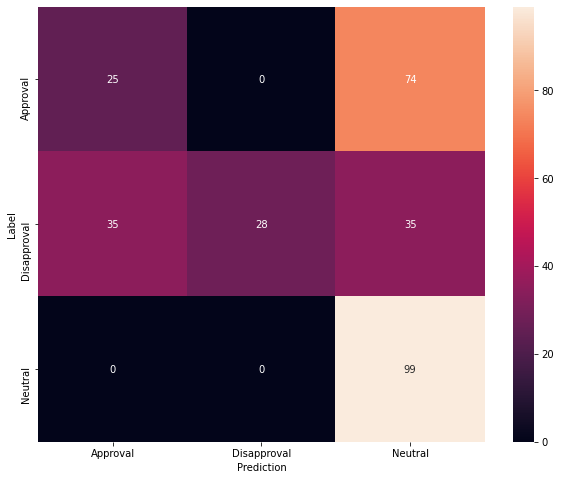

In [12]:
# confusion_mtx_valentina = tf.math.confusion_matrix(y_true, y_pred) 
confusion_mtx_valentina = (confusion_matrix(y_true, y_pred, normalize='true') * 100).astype('int')
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_valentina, xticklabels=EMOTIONS, yticklabels=EMOTIONS, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [13]:
summary = []
CONFIG['training_time'] = training_time
CONFIG['testing_time'] = testing_time
CONFIG['cm_atick'] = np.array2string(confusion_mtx_atick)
result_list_atick = result_atick.split('\n')
CONFIG['cr_atick'] = result_list_atick
CONFIG['cm_valentina'] = np.array2string(confusion_mtx_valentina)
result_list_valentina = result_valentina.split('\n')
CONFIG['cr_valentina'] = result_list_valentina

In [14]:
config = json.dumps(CONFIG, indent=4)
print(config)

{
    "timestamp": "2021-05-24 15:05:06.437473",
    "model": "Random Forest PyAudioAnalysis Features",
    "test_fold": "Fold 5",
    "criterion": "gini",
    "n_estimators": 32,
    "max_depth": 16,
    "training_time": 0.7252798080444336,
    "testing_time": 0.009947776794433594,
    "cm_atick": "[[88  0 11]\n [ 0 97  2]\n [ 5  2 92]]",
    "cr_atick": [
        "              precision    recall  f1-score   support",
        "",
        "         0.0       0.95      0.88      0.92       677",
        "         1.0       0.93      0.98      0.95       253",
        "         2.0       0.87      0.92      0.90       605",
        "",
        "    accuracy                           0.91      1535",
        "   macro avg       0.92      0.93      0.92      1535",
        "weighted avg       0.92      0.91      0.91      1535",
        ""
    ],
    "cm_valentina": "[[25  0 74]\n [35 28 35]\n [ 0  0 99]]",
    "cr_valentina": [
        "              precision    recall  f1-score   supp

In [15]:
f = open(LOG_FILE, 'a')
f.write('\n')
f.write(config)
f.write('\n')
f.close()